# Sagemaker Training Pipelines

## Overview of ML Workflow

In this notebook, we outline the key steps in the machine learning workflow using Amazon SageMaker. The process involves training an XGBoost model with the following steps:

1. **Data Preprocessing:** The raw data is cleaned and transformed to create features, and then it is split into training, validation, and test datasets.
2. **Hyperparameter Tuning:** The model's hyperparameters are tuned using SageMaker's XGBoost framework to find the best-performing model, with the AUC score as the metric for evaluation.
3. **Model Evaluation:** The trained model is evaluated using the test dataset, and the AUC score is compared against a predefined threshold to assess performance.
4. **Model Registration:** If the model meets the threshold AUC score, it is registered in the SageMaker model registry for further use in deployment.

This notebook walks through the process of setting up, training, and evaluating the model, ensuring that we achieve optimal performance before registering it for deployment.

#### Installing Required Libraries

In [29]:
# Install or upgrade the boto3 library, which is used to interact with AWS services
!pip install --upgrade boto3

# Install openpyxl library to work with Excel files
!pip install openpyxl

# Install diagrams library to help create architecture diagrams
!pip install diagrams

#### High-Level ML Workflow Architecture

This diagram represents the high-level architecture of the machine learning workflow. The workflow consists of several key steps to train the model efficiently using Amazon SageMaker.

The **Train Pipeline** includes the following steps:

1. **Preprocess Data:** The first step involves preprocessing the raw data to build the necessary features and split it into train, validation, and test datasets.
2. **Hyperparameter Tuning:** This step involves tuning the model’s hyperparameters using the SageMaker XGBoost framework, aiming to find the best model based on the highest AUC score.
3. **Model Evaluation:** After training, the model is evaluated on the test dataset to ensure it meets the required AUC score, which indicates the model's performance.
4. **Model Registration:** If the model's AUC score meets the predefined threshold, it is then registered into the SageMaker model registry for future use.

##### ML Workflow Diagram

The following diagram illustrates the machine learning workflow, from data storage to model registration, with key steps in the process:

In [32]:
from diagrams import Diagram, Edge
from diagrams.aws.storage import S3
from diagrams.aws.ml import Sagemaker
from diagrams.aws.management import Cloudwatch

with Diagram("High-Level ML Workflow Architecture", show=False, direction="LR"):
    # Components
    s3 = S3("S3 Bucket")

    preprocessing = Sagemaker("Preprocess Data")
    tuning = Sagemaker("Hyperparameter Tuning")
    evaluation = Sagemaker("Model Evaluation")
    condition = Cloudwatch("Check AUC Score")
    model_registry = Sagemaker("Model Registry")

    # Workflow
    s3 >> preprocessing >> tuning >> evaluation >> condition
    condition >> Edge(label="AUC > Threshold") >> model_registry



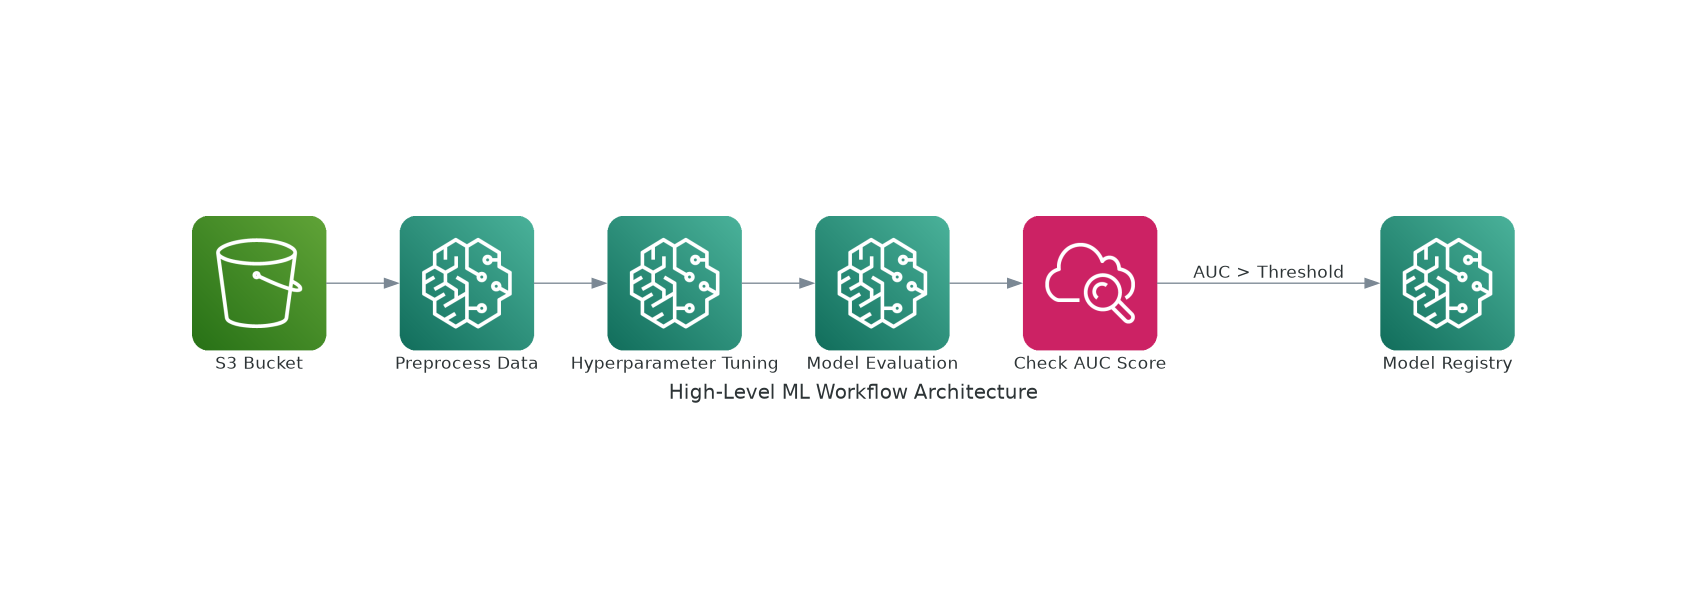

In [35]:
from IPython.display import Image
Image(filename="high-level_ml_workflow_architecture.png")

## Build Pipeline Components

### Pre-requisites

#### Initializing AWS Services and SageMaker Session

In this step, we initialize the necessary AWS services and set up the SageMaker session. We create an S3 client to interact with Amazon S3, define the pipeline name, and set up the SageMaker session for interacting with the SageMaker environment. Additionally, we retrieve the execution role, region, and default S3 bucket for storing data and models. These configurations are crucial for running the pipeline and managing resources.

In [36]:
# Import necessary libraries for AWS and SageMaker operations
import boto3
import pandas as pd
import sagemaker
from sagemaker.workflow.pipeline_context import PipelineSession

# Initialize the S3 client to interact with S3 buckets
s3_client = boto3.resource('s3')

# Define the pipeline name for training
pipeline_name = f"sagemaker-mlops-train-pipeline"

# Create a SageMaker session object to interact with SageMaker
sagemaker_session = sagemaker.Session()

# Get the current region for AWS resources
region = sagemaker_session.boto_region_name

# Get the execution role for SageMaker to access AWS resources
role = sagemaker.get_execution_role()

# Initialize a pipeline session object to manage the workflow
pipeline_session = PipelineSession()

# Get the default S3 bucket for the SageMaker session to store data and models
default_bucket = sagemaker_session.default_bucket()

# Define the model package group name for version control in the model registry
model_package_group_name = f"ChurnModelPackageGroup"

#### Defining Workflow Parameters

In this step, we define the parameters required for the machine learning workflow. These parameters include the number of processing instances, instance types for training and processing, the input data file, and the model approval status. Additionally, we set a threshold for the AUC score to evaluate the model's performance. These parameters allow us to configure the pipeline dynamically and modify the workflow as needed.

In [37]:
# Import necessary classes for defining parameters in the workflow
from sagemaker.workflow.parameters import (
    ParameterInteger, 
    ParameterString, 
    ParameterFloat
)

# Set the AUC score threshold for model evaluation
auc_score_threshold = 0.75

# Define the base job prefix for naming SageMaker jobs
base_job_prefix = "churn-example"

# Define the number of processing instances (default to 1)
processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)

# Define the instance type for processing (default to 'ml.m5.xlarge')
processing_instance_type = ParameterString(name="ProcessingInstanceType", default_value="ml.m5.xlarge")

# Define the instance type for training (default to 'ml.m5.xlarge')
training_instance_type = ParameterString(name="TrainingInstanceType", default_value="ml.m5.xlarge")

# Specify the input data file for the training process
input_data = "storedata_total.csv"

# Define the model approval status (default to 'PendingManualApproval')
model_approval_status = ParameterString(name="ModelApprovalStatus", default_value="PendingManualApproval")


### Collect & Prepare Data

#### Downloading the Dataset

In [40]:
# Use wget to download the dataset from the GitHub repository
!wget --no-check-certificate https://github.com/garganshulgarg/learn-mlops-with-sagemaker/raw/refs/heads/sagemaker-train-pipeline/applications/4-sagemaker-model-train-pipeline/dataset/storedata_total.xlsx

--2024-11-18 14:10:57--  https://github.com/garganshulgarg/learn-mlops-with-sagemaker/raw/refs/heads/sagemaker-train-pipeline/applications/4-sagemaker-model-train-pipeline/dataset/storedata_total.xlsx
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/garganshulgarg/learn-mlops-with-sagemaker/refs/heads/sagemaker-train-pipeline/applications/4-sagemaker-model-train-pipeline/dataset/storedata_total.xlsx [following]
--2024-11-18 14:10:58--  https://raw.githubusercontent.com/garganshulgarg/learn-mlops-with-sagemaker/refs/heads/sagemaker-train-pipeline/applications/4-sagemaker-model-train-pipeline/dataset/storedata_total.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent

#### Converting Excel Data to CSV Format

In this step, we load the Excel dataset using pandas and convert it into a CSV format. This will allow us to work with the data more easily in the SageMaker pipeline, as CSV is a common format for training machine learning models.

In [47]:
# Load the dataset from the downloaded Excel file
store_data = pd.read_excel("storedata_total.xlsx")

# Convert the dataset into a CSV format and save it as "storedata_total.csv"
store_data.to_csv("storedata_total.csv", index=False)

/opt/conda/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### Defining the PreProcessing Step (Preprocess Data) in SageMaker Pipeline

#### Downloading the Preprocessing Script

In this step, we download the preprocessing script (preprocess-churn.py) from the GitHub repository. This script will be used in the preprocessing step of the SageMaker pipeline to transform and prepare the data for model training.

In [42]:
# Use wget to download the preprocessing script from the GitHub repository
!wget --no-check-certificate https://github.com/garganshulgarg/learn-mlops-with-sagemaker/raw/refs/heads/sagemaker-train-pipeline/applications/4-sagemaker-model-train-pipeline/preprocess-churn.py

--2024-11-18 14:15:22--  https://github.com/garganshulgarg/learn-mlops-with-sagemaker/raw/refs/heads/sagemaker-train-pipeline/applications/4-sagemaker-model-train-pipeline/preprocess-churn.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/garganshulgarg/learn-mlops-with-sagemaker/refs/heads/sagemaker-train-pipeline/applications/4-sagemaker-model-train-pipeline/preprocess-churn.py [following]
--2024-11-18 14:15:22--  https://raw.githubusercontent.com/garganshulgarg/learn-mlops-with-sagemaker/refs/heads/sagemaker-train-pipeline/applications/4-sagemaker-model-train-pipeline/preprocess-churn.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent

#### Viewing the Preprocessing Script

In this step, we use pygmentize to display the content of the preprocess-churn.py script in a more readable, highlighted format. This helps us review the script to understand the preprocessing logic before using it in the SageMaker pipeline.

In [46]:
# Use pygmentize to display the content of the preprocessing script with syntax highlighting
!pygmentize "preprocess-churn.py"

import os
import tempfile
import numpy as np
import pandas as pd
import datetime as dt
if __name__ == "__main__":
    base_dir = "/opt/ml/processing"
    #Read Data
    df = pd.read_csv(
        f"{base_dir}/input/storedata_total.csv"
    )
    # convert created column to datetime
    df["created"] = pd.to_datetime(df["created"])
    #Convert firstorder and lastorder to datetime datatype
    df["firstorder"] = pd.to_datetime(df["firstorder"],errors='coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
    #Drop Rows with Null Values
    df = df.dropna()
    #Create column which gives the days between the last order and the first order
    df['first_last_days_diff'] = (df['lastorder'] - df['firstorder']).dt.days
    #Create column which gives the days between the customer record was created and the first order
    df['created_first_days_diff'] = (df['created'] - df['firstorder']).dt.days
    #Drop columns
    df.drop(['custid', 'created','firstorder','lastorder

#### Defining the Feature Engineering PreProcessing Step

In this step, we define the Feature Engineering processing step within the SageMaker pipeline. The feature engineering step is responsible for preparing the features required for model training. We use the SKLearnProcessor to run the preprocess-churn.py script, which performs data preprocessing and splits the data into training, validation, and test sets. The outputs are stored in S3 for later use in the model training step.

In [49]:
# Import necessary libraries for defining the processing step
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

# Define the framework version and SKLearnProcessor for feature engineering
framework_version = "1.0-1"
sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    instance_type=processing_instance_type,  # Use ml.m5.xlarge instance type for processing
    instance_count=processing_instance_count,  # Number of instances for processing
    base_job_name="sklearn-churn-process",  # Prefix for the job names
    role=role,  # Execution role for SageMaker
    sagemaker_session=pipeline_session,  # SageMaker session to run the job
)

# Define the processing step inputs and outputs
processor_args = sklearn_processor.run(
    inputs=[
        ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),  # Input data
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train", 
                         destination=f"s3://{default_bucket}/output/train"),  # Training data output
        ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation", 
                         destination=f"s3://{default_bucket}/output/validation"),  # Validation data output
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test", 
                         destination=f"s3://{default_bucket}/output/test"),  # Test data output
    ],
    code="preprocess-churn.py",  # Path to the preprocessing script
)

# Define the processing step in the pipeline
step_process = ProcessingStep(name="ChurnModelProcess", step_args=processor_args)


INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


In [14]:
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.workflow.steps import TuningStep

model_path = f"s3://{default_bucket}/output"
image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.0-1",
    py_version="py3",
    instance_type=training_instance_type,
)
fixed_hyperparameters = {
"eval_metric":"auc",
"objective":"binary:logistic",
"num_round":"100",
"rate_drop":"0.3",
"tweedie_variance_power":"1.4"
}
xgb_train = Estimator(
    image_uri=image_uri,
    instance_type=training_instance_type,
    instance_count=1,
    hyperparameters=fixed_hyperparameters,
    output_path=model_path,
    base_job_name=f"churn-train",
    sagemaker_session=pipeline_session,
    role=role,
)

The input argument instance_type of function (sagemaker.image_uris.retrieve) is a pipeline variable (<class 'sagemaker.workflow.parameters.ParameterString'>), which is interpreted in pipeline execution time only. As the function needs to evaluate the argument value in SDK compile time, the default_value of this Parameter object will be used to override it. Please make sure the default_value is valid.


In [15]:
hyperparameter_ranges = {
"eta": ContinuousParameter(0, 1),
"min_child_weight": ContinuousParameter(1, 10),
"alpha": ContinuousParameter(0, 2),
"max_depth": IntegerParameter(1, 10),
}
objective_metric_name = "validation:auc"

tuner = HyperparameterTuner(
    xgb_train,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=2,
    max_parallel_jobs=2,
)

hpo_args = tuner.fit(
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "validation": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                "validation"
            ].S3Output.S3Uri,
            content_type="text/csv",
        ),
    }
)

step_tuning = TuningStep(
    name="ChurnHyperParameterTuning",
    step_args=hpo_args,
)

In [16]:
!wget --no-check-certificate https://raw.githubusercontent.com/manifoldailearning/mlops-with-aws-datascientists/main/Section-16-mlops-pipeline/evaluate-churn.py

--2024-11-18 13:27:35--  https://raw.githubusercontent.com/manifoldailearning/mlops-with-aws-datascientists/main/Section-16-mlops-pipeline/evaluate-churn.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1309 (1.3K) [text/plain]
Saving to: ‘evaluate-churn.py’

evaluate-churn.py   100%[===================>]   1.28K  --.-KB/s    in 0s      

2024-11-18 13:27:35 (54.1 MB/s) - ‘evaluate-churn.py’ saved [1309/1309]



In [17]:
!pygmentize "evaluate-churn.py"

import json
import pathlib
import pickle
import tarfile
import joblib
import numpy as np
import pandas as pd
import xgboost
import datetime as dt
from sklearn.metrics import roc_curve,auc
if __name__ == "__main__":   
    #Read Model Tar File
    model_path = f"/opt/ml/processing/model/model.tar.gz"
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")
    model = pickle.load(open("xgboost-model", "rb"))
    #Read Test Data using which we evaluate the model
    test_path = "/opt/ml/processing/test/test.csv"
    df = pd.read_csv(test_path, header=None)
    y_test = df.iloc[:, 0].to_numpy()
    df.drop(df.columns[0], axis=1, inplace=True)
    X_test = xgboost.DMatrix(df.values)
    #Run Predictions
    predictions = model.predict(X_test)
    #Evaluate Predictions
    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    auc_score = auc(fpr, tpr)
    report_dict = {
        "classification_metrics": {
            "auc_score": {
                "value": auc_score,


In [18]:
# define model evaluation step to evaluate the trained model
from sagemaker.processing import ScriptProcessor
script_eval = ScriptProcessor(
    image_uri=image_uri,
    command=["python3"],
    instance_type=processing_instance_type,
    instance_count=1,
    base_job_name="script-churn-eval",
    role=role,
    sagemaker_session=pipeline_session,
)
eval_args = script_eval.run(
     inputs=[
            ProcessingInput(
                source=step_tuning.get_top_model_s3_uri(top_k=0,s3_bucket=default_bucket,prefix="output"),
                destination="/opt/ml/processing/model"
            ),
            ProcessingInput(
                source=step_process.properties.ProcessingOutputConfig.Outputs[
                    "test"
                ].S3Output.S3Uri,
                destination="/opt/ml/processing/test"
            )
        ],
    outputs=[
            ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation",\
                             destination=f"s3://{default_bucket}/output/evaluation"),
        ],
    code=f"evaluate-churn.py",
)
from sagemaker.workflow.properties import PropertyFile

evaluation_report = PropertyFile(
    name="ChurnEvaluationReport", output_name="evaluation", path="evaluation.json"
)
step_eval = ProcessingStep(
    name="ChurnEvalModel",
    step_args=eval_args,
    property_files=[evaluation_report],
)

/opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


In [19]:
from sagemaker import Model
from sagemaker.workflow.model_step import ModelStep

model = Model(
    image_uri=image_uri,
    model_data=step_tuning.get_top_model_s3_uri(top_k=0,s3_bucket=default_bucket,prefix="output"),
    sagemaker_session=pipeline_session,
    role=role,
)
from sagemaker.model_metrics import MetricsSource, ModelMetrics

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),
        content_type="application/json",
    )
)
register_args = model.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=model_package_group_name,
    approval_status=model_approval_status,
    model_metrics=model_metrics,
)
step_register = ModelStep(name="ChurnRegisterModel", step_args=register_args)

In [20]:
from sagemaker.workflow.conditions import ConditionGreaterThan
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet
cond_lte = ConditionGreaterThan(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="classification_metrics.auc_score.value",
    ),
    right=auc_score_threshold,
)
step_cond = ConditionStep(
    name="CheckAUCScoreChurnEvaluation",
    conditions=[cond_lte],
    if_steps=[step_register],
)

In [21]:
import json
from sagemaker.workflow.pipeline import Pipeline

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_count,
        processing_instance_type,
        training_instance_type,
        model_approval_status,
        input_data,
        auc_score_threshold,
    ],
    steps=[step_process, step_tuning, step_eval, step_cond],
) 
definition = json.loads(pipeline.definition())
print(definition)

{'Version': '2020-12-01', 'Metadata': {}, 'Parameters': [{'Name': 'ProcessingInstanceCount', 'Type': 'Integer', 'DefaultValue': 1}, {'Name': 'ProcessingInstanceType', 'Type': 'String', 'DefaultValue': 'ml.m5.xlarge'}, {'Name': 'TrainingInstanceType', 'Type': 'String', 'DefaultValue': 'ml.m5.xlarge'}, {'Name': 'ModelApprovalStatus', 'Type': 'String', 'DefaultValue': 'PendingManualApproval'}], 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'}, 'TrialName': {'Get': 'Execution.PipelineExecutionId'}}, 'Steps': [{'Name': 'ChurnModelProcess', 'Type': 'Processing', 'Arguments': {'ProcessingResources': {'ClusterConfig': {'InstanceType': 'ml.m5.xlarge', 'InstanceCount': {'Get': 'Parameters.ProcessingInstanceCount'}, 'VolumeSizeInGB': 30}}, 'AppSpecification': {'ImageUri': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:1.0-1-cpu-py3', 'ContainerEntrypoint': ['python3', '/opt/ml/processing/input/code/preprocess-churn.py']}, 'RoleArn': 'arn:aws:i

In [22]:
# Create a new or update existing Pipeline
pipeline.upsert(role_arn=role)
# start Pipeline execution
pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:607119565685:pipeline/sagemaker-mlops-train-pipeline/execution/mhthysvhv0ai', sagemaker_session=<sagemaker.session.Session object at 0x7f9ee4a64490>)